MovieWriter ffmpeg unavailable; using Pillow instead.


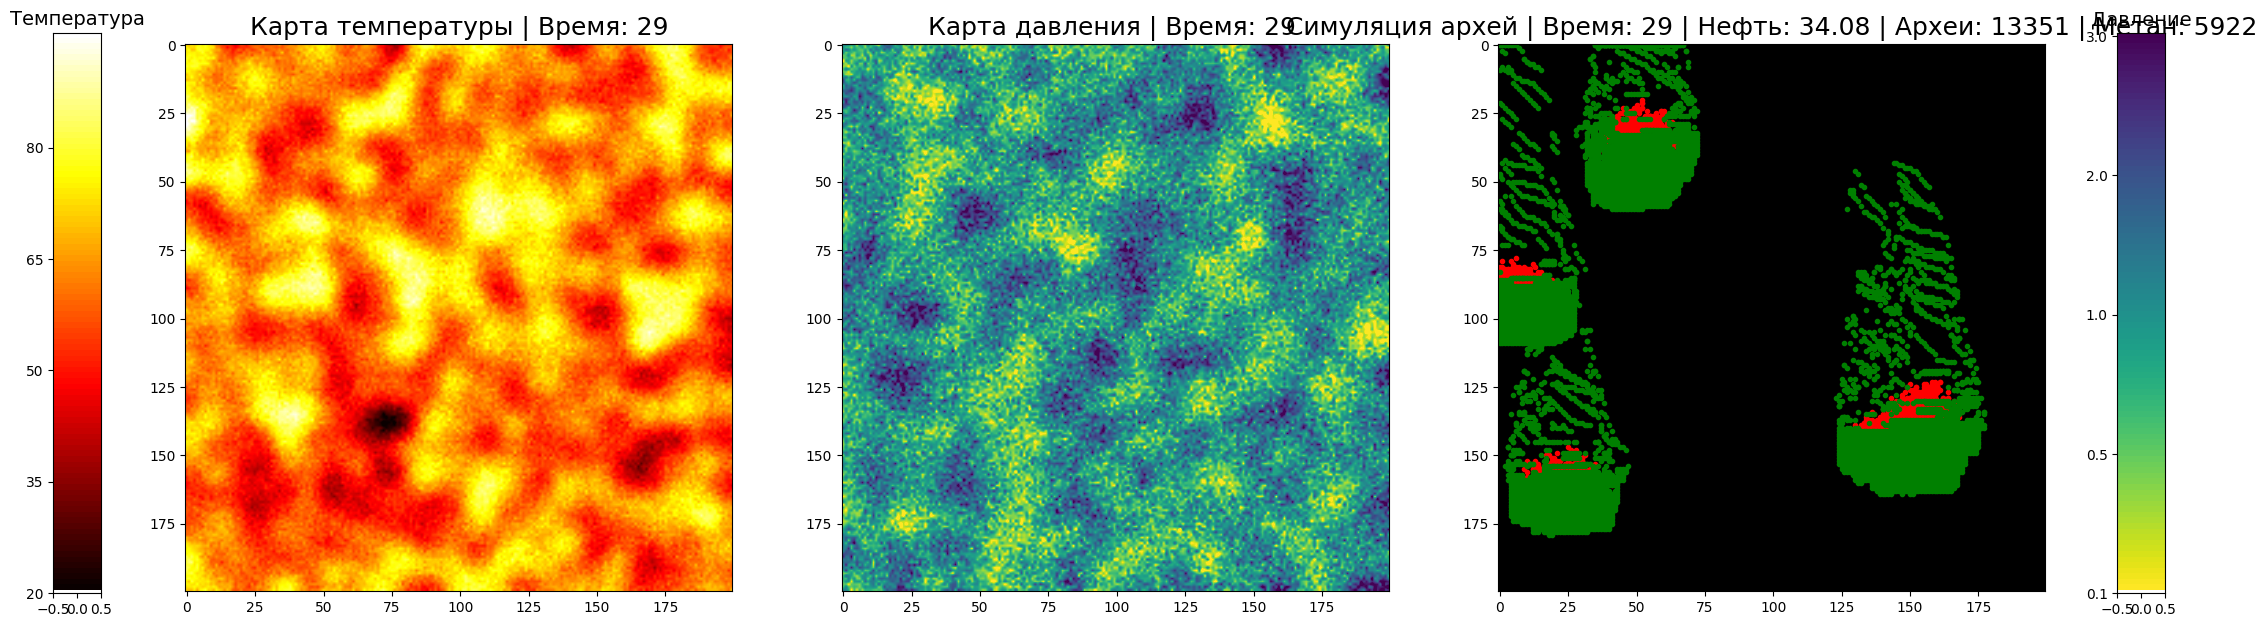

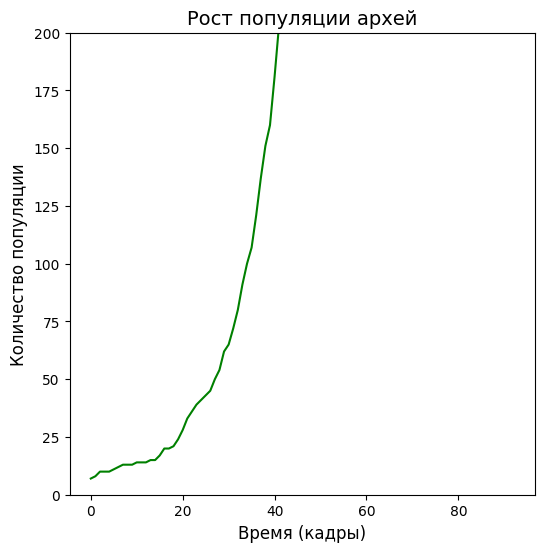

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
import random
from scipy.ndimage import gaussian_filter

# Параметры
GRID_SIZE = 200  # Размер сетки
INITIAL_ARCHEA_COUNT = 5  # Начальное количество архей
ARCHEA_MOVEMENT_PROBABILITY = 0.5  # Вероятность движения архей
ARCHEA_REPRODUCTION_PROBABILITY = 0.1  # Вероятность размножения архей
CONSUMPTION_RADIUS = 6  # Радиус потребления нефти вокруг архей
STARVATION_FRAMES = 20  # Количество кадров без нефти перед смертью архей

# Условия выживания архей
OPTIMAL_TEMPERATURE = (30, 60)  # Оптимальная температура в градусах Цельсия
OPTIMAL_PRESSURE = (0.5, 2)  # Оптимальное давление в атмосферах

# Создание сетки - вся заполненная нефтью
grid = np.ones((GRID_SIZE, GRID_SIZE), dtype=bool)  # Сетка нефти (все значения True)
temperature_map = gaussian_filter(np.random.uniform(20, 80, (GRID_SIZE, GRID_SIZE)), sigma=5)  # Температура от 20 до 80°C
pressure_map = gaussian_filter(np.random.uniform(0.1, 3, (GRID_SIZE, GRID_SIZE)), sigma=5)  # Давление от 0.1 до 3 атм

# Инициализация позиций архей
def initialize_archea_positions(initial_count, grid):
    positions = []
    
    while len(positions) < initial_count:
        x = random.randint(0, GRID_SIZE - 1)
        y = random.randint(0, GRID_SIZE - 1)
        if grid[x, y]:  # Проверяем, чтобы это была ячейка с нефтью
            positions.append((x, y))

    return np.array(positions)

# Инициализация архей
archea_positions = initialize_archea_positions(INITIAL_ARCHEA_COUNT, grid)

# Список для хранения позиций метана
methane_positions = []

# Создание фигуры и осей для анимации
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
ax1.set_title("Карта температуры", fontsize=14)
ax2.set_title("Карта давления", fontsize=14)
ax3.set_title("Симуляция архей и метана", fontsize=14)
cmap_temp = plt.get_cmap('hot')  # Цвета для температуры (теплая палитра)
cmap_oil = ListedColormap(['black'])  # Черный для нефти
cmap_archea = ListedColormap(['red'])  # Красный для архей
cmap_methane = ListedColormap(['grey'])  # Серый для метана

# Отображение карты температуры
temp_plot = ax1.imshow(temperature_map, cmap=cmap_temp, interpolation='bilinear')

# Отображение карты давления
pressure_plot = ax2.imshow(pressure_map, interpolation='bilinear')

# Отображение сетки с нефтью, метаном и археями
oil_plot = ax3.imshow(grid, cmap=cmap_oil, interpolation='nearest')  # Все заполнено нефтью
archea_plot, = ax3.plot(archea_positions[:, 1], archea_positions[:, 0], 'ro', markersize=3)  # Археи красным цветом

# Добавление цветовых шкал для температуры и давления
temp_bar = fig.add_axes([0.07, 0.15, 0.02, 0.7])
temp_bar.set_title("Температура", fontsize=14)
temp_bar.imshow(np.linspace(80, 20, 100).reshape(100, 1), cmap=cmap_temp, aspect='auto')
temp_bar.set_yticks([100, 80, 60, 40, 20])
temp_bar.set_yticklabels([20, 35, 50, 65, 80])

pressure_bar = fig.add_axes([0.93, 0.15, 0.02, 0.7])
pressure_bar.set_title("Давление", fontsize=14)
pressure_bar.imshow(np.linspace(0.1, 3, 100).reshape(100, 1), aspect='auto')
pressure_bar.set_yticks([100, 75, 50, 25, 0])
pressure_bar.set_yticklabels([0.1, 0.5, 1.0, 2.0, 3.0])

# Добавление счетчиков голода и здоровья для каждой археи
starvation_counters = np.zeros(len(archea_positions), dtype=int)
health_counters = np.zeros(len(archea_positions), dtype=int)  # Счетчик здоровья

# Список для отслеживания популяции со временем
population_history = []

# Функция для вычисления и отображения статистики
def calculate_statistics(grid, archea_positions):
    oil_count = np.sum(grid)  # Количество нефти
    archaea_count = len(archea_positions)  # Количество архей
    methane_count = len(methane_positions)  # Количество метана
    return oil_count, archaea_count, methane_count

# Функция для обновления кадра анимации
def animate(frame):
    global archea_positions, grid, temperature_map, pressure_map, starvation_counters, health_counters, population_history
    global methane_positions

    # Обновление карт температуры и давления с плавной анимацией
    temperature_map += np.random.uniform(-0.5, 0.5, (GRID_SIZE, GRID_SIZE)) / 10
    pressure_map += np.random.uniform(-0.1, 0.1, (GRID_SIZE, GRID_SIZE)) / 10

    # Обновление отображения карты температуры
    temp_plot.set_array(temperature_map)

    # Обновление отображения карты давления
    pressure_plot.set_array(pressure_map)

    # Проверка условия выживания для архей
    for i in range(len(archea_positions)):
        x, y = archea_positions[i]
        if (temperature_map[x, y] < OPTIMAL_TEMPERATURE[0] or temperature_map[x, y] > OPTIMAL_TEMPERATURE[1] or
                pressure_map[x, y] < OPTIMAL_PRESSURE[0] or pressure_map[x, y] > OPTIMAL_PRESSURE[1]):
            health_counters[i] += 1  # Увеличение счетчика здоровья
        else:
            health_counters[i] = 0  # Сброс счетчика здоровья

    # Удаление архей, если здоровье ухудшается
    dead_archea_indices = np.where(health_counters >= 10)[0]
    if dead_archea_indices.size > 0:
        archea_positions = np.delete(archea_positions, dead_archea_indices, axis=0)
        starvation_counters = np.delete(starvation_counters, dead_archea_indices)
        health_counters = np.delete(health_counters, dead_archea_indices)

    # Движение архей
    for i, (x, y) in enumerate(archea_positions):
        if random.random() < ARCHEA_MOVEMENT_PROBABILITY:
            # Выбор случайного направления
            direction = random.randint(0, 3)
            if direction == 0 and x < GRID_SIZE - 1:  # Двигаться вправо
                x += 1
            elif direction == 1 and x > 0:  # Двигаться влево
                x -= 1
            elif direction == 2 and y < GRID_SIZE - 1:  # Двигаться вниз
                y += 1
            elif direction == 3 and y > 0:  # Двигаться вверх
                y -= 1
            archea_positions[i] = (x, y)

    # Размножение архей
    new_archea_positions = []
    for i, (x, y) in enumerate(archea_positions):
        if random.random() < ARCHEA_REPRODUCTION_PROBABILITY:
            # Выбор случайного направления для новых архей
            direction = random.randint(0, 3)
            if direction == 0 and x < GRID_SIZE - 1:  # Двигаться вправо
                new_archea_positions.append((x + 1, y))
            elif direction == 1 and x > 0:  # Двигаться влево
                new_archea_positions.append((x - 1, y))
            elif direction == 2 and y < GRID_SIZE - 1:  # Двигаться вниз
                new_archea_positions.append((x, y + 1))
            elif direction == 3 and y > 0:  # Двигаться вверх
                new_archea_positions.append((x, y - 1))

    new_archea_positions = np.array(new_archea_positions)
    if new_archea_positions.size > 0:
        archea_positions = np.vstack((archea_positions, new_archea_positions))
        starvation_counters = np.append(starvation_counters, np.zeros(len(new_archea_positions), dtype=int))
        health_counters = np.append(health_counters, np.zeros(len(new_archea_positions), dtype=int))

    # Потребление нефти вокруг архей и создание метана
    for i in range(len(archea_positions)):
        x, y = archea_positions[i]
        found_oil = False
        for dx in range(-CONSUMPTION_RADIUS, CONSUMPTION_RADIUS + 1):
            for dy in range(-CONSUMPTION_RADIUS, CONSUMPTION_RADIUS + 1):
                nx = x + dx
                ny = y + dy
                if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE and grid[nx, ny]:
                    grid[nx, ny] = False  # Потребляем нефть
                    methane_positions.append((nx, ny))  # Добавляем позицию метана
                    found_oil = True
                    break
            if found_oil:
                break
        if found_oil:
            starvation_counters[i] = 0
        else:
            starvation_counters[i] += 1

    dead_archea_indices = np.where(starvation_counters >= STARVATION_FRAMES)[0]
    if dead_archea_indices.size > 0:
        archea_positions = np.delete(archea_positions, dead_archea_indices, axis=0)
        starvation_counters = np.delete(starvation_counters, dead_archea_indices)
        health_counters = np.delete(health_counters, dead_archea_indices)

    # Перемещение метана вверх по закону Архимеда
    new_methane_positions = []
    for mx, my in methane_positions:
        if mx > 0 and grid[mx - 1, my]:  # Проверяем, можно ли поднять метан вверх
            new_methane_positions.append((mx - 1, my))  # Перемещаем метан вверх
        else:
            new_methane_positions.append((mx, my))  # Удерживаем метан на месте

    # Обновляем список позиций метана
    methane_positions = new_methane_positions

    # Обновление отображения метана и архей
    ax3.clear()  # Очистка оси для обновления
    ax3.imshow(grid, cmap=cmap_oil, interpolation='nearest')  # Обновление сетки нефти
    ax3.plot(archea_positions[:, 1], archea_positions[:, 0], 'ro', markersize=3)  # Археи
    for mx, my in methane_positions:
        ax3.plot(my, mx, 'go', markersize=3)  # Метан (зеленые клетки)

    # Статистика
    stats = calculate_statistics(grid, archea_positions)
    ax1.set_title(f"Карта температуры | Время: {frame}", fontsize=18)
    ax2.set_title(f"Карта давления | Время: {frame} ", fontsize=18)
    ax3.set_title(f"Симуляция архей | Время: {frame} | Нефть: {stats[0] / 1000:.2f} | Археи: {stats[1]} | Метан: {stats[2]}", fontsize=18)

    # Обновление истории популяции
    population_history.append(len(archea_positions))
    return temp_plot, pressure_plot, oil_plot, archea_plot

# Создание фигуры и осей для графика роста популяции
fig2, ax5 = plt.subplots(figsize=(6, 6))
ax5.set_title("Рост популяции архей", fontsize=14)
ax5.set_xlabel("Время (кадры)", fontsize=12)
ax5.set_ylabel("Количество популяции", fontsize=12)
ax5.set_ylim(0, GRID_SIZE)  # Установка ограничения оси Y на основе размера сетки

# Создание анимации
ani = animation.FuncAnimation(fig, animate, frames=60, interval=300, blit=True)
ani.save('full_version.gif')
# Отображение отдельного графика роста популяции
def update_population_graph():
    ax5.clear()
    ax5.plot(population_history, color='green')
    ax5.set_title("Рост популяции архей", fontsize=14)
    ax5.set_xlabel("Время (кадры)", fontsize=12)
    ax5.set_ylabel("Количество популяции", fontsize=12)
    ax5.set_ylim(0, GRID_SIZE)  # Установка ограничения оси Y на основе размера сетки
    plt.draw()

# Обновление графика популяции в цикле
for frame in range(30):
    animate(frame)
    update_population_graph()

plt.show()
